# Acknowledgement

Parts of this pset were inspired by
* Berkeley CS294-158, taught by Pieter Abbeel, Wilson Yan, Kevin Frans, and Philipp Wu;
* MIT 6.S184/6.S975, taught by Peter Holderrieth and Ezra Erives;
* The [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) about diffusion models by Lilian Weng.




# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 3 in this notebook, the pdf should contain:
- The generated figures `results/mnist_train_plot.png` and `results/image_w{w}.png` (w=0.0, 0.5, 1.0, 2.0, 4.0)
- Answer to the short answer question about the U-Net architecture
- Answer to the short answer question about different CFG weight $w$ in problem 3.2

# Problem 3: MNIST and Conditional Generation
In this problem, we will write the code for conditional generation on the MNIST dataset. This part requires GPUs--you can use Google Colab for GPU access. To work on this notebook in Google Colab, copy the `pset-5` directory to your Google Drive and open this notebook. Then, start working on a GPU machine with `Runtime -> Change runtime type -> T4 GPU`.

## MNIST Dataset


In [1]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

tf = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST("./data", train=True, download=True, transform=tf)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = MNIST("./data", train=False, download=True, transform=tf)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.02MB/s]


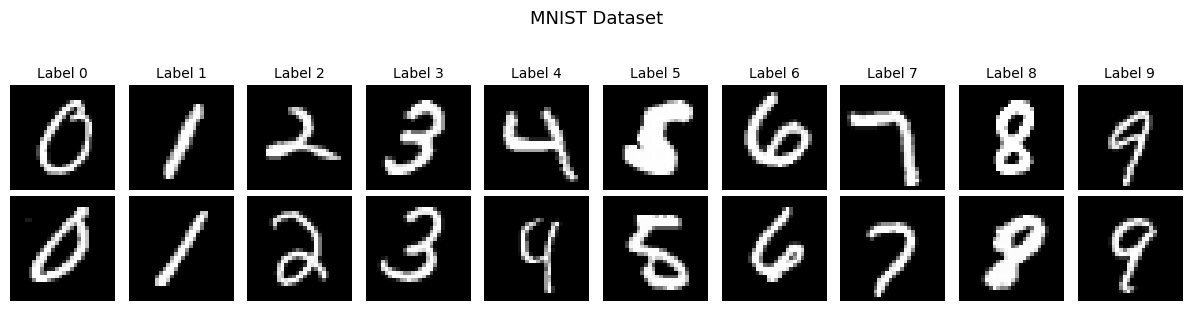

In [2]:
# visualize data by label
import matplotlib.pyplot as plt

images_by_label = {i: [] for i in range(10)}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        if len(images_by_label[label.item()]) < 2:
            images_by_label[label.item()].append(img.squeeze(0))
        if all(len(images) == 2 for images in images_by_label.values()):
            break
    if all(len(images) == 2 for images in images_by_label.values()):
        break

# Plot the images
fig, axes = plt.subplots(2, 10, figsize=(12, 3))
fig.suptitle("MNIST Dataset", fontsize=13, y=1.05)

for label, imgs in images_by_label.items():
    for i, img in enumerate(imgs):
        ax = axes[i, label]
        ax.imshow(img.numpy(), cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title(f"Label {label}", fontsize=10)

plt.tight_layout(pad=1.0)
plt.show()

## 3.1 U-Net: Architecture for Image Data
In the toy dataset, we choose MLP as the architecture of the denoising diffusion models, and use concatenation as the way to incorporate the time embedding. Although this works fine for simple synthetic distributions, it no longer suffices for complex high-dimensional distributions like images. In this problem, we will introduce the U-Net architecture specifically designed for images.

Specifically, we apply [classifier-free guidance](https://arxiv.org/pdf/2207.12598) (CFG) for conditional generation of MNIST digits, conditioned on the digit label. CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

When applying CFG, the label embedding, together with the time embedding, is added to each hidden layer of the U-Net. A diagram of the U-Net we'll be using is shown below (we change BatchNorm to GroupNorm for better performance).

In [3]:
from typing import List
import torch.nn as nn
import math
import torch
import os
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from matplotlib.pyplot import savefig

In [26]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1, 1, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        t = t.view(-1, 1) # (bs, 1)
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)

class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=channels),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=channels),
            nn.SiLU(),
        )
        # Converts (bs, time_embed_dim) -> (bs, channels)
        self.time_adapter = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )
        # Converts (bs, y_embed_dim) -> (bs, channels)
        self.y_adapter = nn.Sequential(
            nn.SiLU(),
            nn.Linear(y_embed_dim, channels)
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        res = x.clone() # (bs, c, h, w)

        # Initial conv block
        x = self.block1(x) # (bs, c, h, w)

        # Add time embedding
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + t_embed

        # Add y embedding (conditional embedding)
        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + y_embed

        # Second conv block
        x = self.block2(x) # (bs, c, h, w)

        # Add back residual
        x = x + res # (bs, c, h, w)

        return x

class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_in, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c_in, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h // 2, w // 2)
        x = self.downsample(x)

        return x

class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c, h, w) -> (bs, c, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1))
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_out, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Upsample: (bs, c_in, h, w) -> (bs, c_out, 2 * h, 2 * w)
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class MNISTUNet(nn.Module):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        # Initial convolution: (bs, 1, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(
            nn.Conv2d(1, channels[0], kernel_size=3, padding=1),
            # nn.BatchNorm2d(channels[0]),
            nn.GroupNorm(num_groups=8, num_channels=channels[0]),
            nn.SiLU()
        )

        # Initialize time embedder
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Initialize y embedder
        self.y_embedder = nn.Embedding(num_embeddings = 11, embedding_dim = y_embed_dim)

        # Encoders, Midcoders, and Decoders
        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim, y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder1 = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)
        self.midcoder2 = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)

        # Final convolution
        self.final_conv = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=channels[0]),
            nn.SiLU(),
            nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: (bs, 1, 32, 32)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, 1, 32, 32)
        """
        # Embed t and y
        t_embed = self.time_embedder(t) # (bs, time_embed_dim)
        y_embed = self.y_embedder(y) # (bs, y_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 32, 32)

        residuals = []

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)
            residuals.append(x.clone())

        # Midcoder
        x = self.midcoder1(x, t_embed, y_embed)
        x = self.midcoder2(x, t_embed, y_embed)

        # Decoders
        for decoder in self.decoders:
            res = residuals.pop() # (bs, c_i, h, w)
            x = x + res
            x = decoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i-1}, 2 * h, 2 * w)

        # Final convolution
        x = self.final_conv(x) # (bs, 1, 32, 32)

        return x

**Please explain each components of the architecture above** (each one of `FourierEncoder`, `ResidualLayer`, `Encoder`, `Decoder`, or `Midcoder`) in your own words, (1) their role in the U-Net, (2) their inputs and outputs, and (3) a brief description of how the inputs turn into outputs.

## 3.2 Classifier-Free Guidance

Implement CFG requires a small modification to the diffusion training and sampling code.

*During training*, we randomly drop out the class label with a certain probability `drop_prob=0.1`, i.e. we use a dummy embedding to replace the digit label embedding.

*During sampling*, given a digit label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which is supported by the dummy embedding during training. Note that $w = 1$ recovers standard sampling.

Please modify the code you wrote for Problem 2 for unconditional generation to adapt for the CFG setting. You can change the model architecture from MLP to UNet. Specifically, given a data element $x$ and U-Net $f_\theta(x, t)$, implement the following diffusion training steps similar as what we did in Problem 2, while using a different noise schedule (in step 2):
0. Construct a class `MNISTDiffusion`
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a linear schedule: $\alpha_t = 1-t, \sigma_t = \sqrt{1-(1-t)^2}$
3. Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and cmpute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

*Note*: you can reuse your code from Problem 2 for functions `train`, `eval_loss`, `get_lr`, and `train_epochs`.

*Hyperparameter details*
* UNet with hidden_dims as [64, 128] and 1 blocks_per_dim
* Train 10 epochs, batch size 128, Adam with LR 1e-3 (0 warmup steps, and `use_cosine_decay=True`)
* Training 10 epochs takes about 7 minutes on the Google Colab T4 GPU.

After training, please generate 4 images for each of the 10 digit labels using guidance strength $w$ of 0.0, 0.5, 1.0, 2.0, 4.0 respectively, and save the images as 4x10 grid of images (each column is a digit). You are required to submit the images for each guidance strength along with the training loss curve. **Comparing the results with different $w$, what can you say about its impact to the generation performance?**

*Hint*: To check your answer, the final test loss is below 0.02.

In [27]:
class MNISTDiffusion:
    def __init__(self, model, data_shape, device, n_classes, drop_prob=0.1):
        """
        model: neural network to estimate eps_hat (U-Net in this problem)
        data_shape: size of the input data, (1, 28, 28) in this case
        device: cuda
        n_classes: number of classes for conditional generation, set to 10 in this problem
        drop_prob: probability of dropping the condition in CFG training
        """
        self.model = model.to(device)
        self.data_shape = data_shape
        self.device = device
        self.drop_prob = drop_prob
        self.n_classes = n_classes
    
    def loss(self, x, y):
        """
        x: the input data (without adding noise) from the dataloader
        y: the class label
        Return:
            The loss (as a scalar averaged over all data in the batch)
        """
        raise NotImplementedError("Please implement this")

    @torch.no_grad()
    def sample(self, n, num_steps, guide_w=0.0):
        """
        n: number of samples to generate (you should generate int(n/n_classes) samples for each class and thus n samples in total)
        num_steps: number of steps in the diffusion sampling
        guide_w: the CFG weight
        Return:
            The generated sample. Tensor with shape (n, *self.data_shape)
        """
        raise NotImplementedError("Please implement this")

    def __getattr__(self, name):
        if name in ['train', 'eval', 'parameters', 'state_dict', 'load_state_dict']:
            return getattr(self.model, name)
        return self.__getattribute__(name)


# You can reuse your implementations in part 2 problem 2 for the following four functions

def train(model, train_loader, optimizer, scheduler):
    """
    model: model to train, the MNISTDiffusion class in this case.
    train_loader: train_loader
    optimizer: use torch.optim.Adam
    scheduler: use optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )
    Return:
        Tensor with train loss of each batch
    """
    raise NotImplementedError("Please implement this")


@torch.no_grad()
def eval_loss(model, data_loader):
    """
    model: model to train, the MNISTDiffusion class in this case.
    data_loader: test_loader
    Return:
        Scalar with the average test loss of each batch
    """
    raise NotImplementedError("Please implement this")


def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    """
    Function that returns the learning rate for the specific step, used in defining the scheduler:
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
        )
    """
    raise NotImplementedError("Please implement this")


def train_epochs(model, train_loader, test_loader, train_args):
    """
    model: model to train, the MNISTDiffusion class in this case.
    train_loader: train_loader
    test_loader: test_loader
    Return:
        Two np.array for all the train losses and test losses at each step
    """
    raise NotImplementedError("Please implement this")

In [37]:
def mnist_diffusion(train_loader, test_loader):
    """
    train_loader: MNIST training data
    test_loader: MNIST test data

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch

    Generate 4 images for each of the 10 digits in `./results/`, using guidance strengths of 0.0, 0.5, 1.0, 2.0, 4.0.
    Save the images as `./results/image_w{w}.png` as 4x10 grid of images (each column is a digit)
    hint: x_gen is the output from model.sample, use the following to generate and save grids
            grid = make_grid(x_gen*-1 + 1, nrow=10)
            save_image(grid, save_dir + f"image_w{w}.png")
    """

    n_classes = 10
    save_dir = './results/'
    os.makedirs(save_dir, exist_ok=True)
    ws_test = [0.0, 0.5, 1.0, 2.0, 4.0] # strength of generative guidance
    num_steps = 512

    model = MNISTUNet(
        channels = [64, 128],
        num_residual_layers = 1,
        t_embed_dim = 64,
        y_embed_dim = 64,
    )
    model = MNISTDiffusion(model, (1, 28, 28), device="cuda", n_classes=n_classes, drop_prob=0.1)

    raise NotImplementedError("Please implement this")

In [38]:
def save_training_plot(
    train_losses: np.ndarray, test_losses: np.ndarray, title: str, fname: str
) -> None:
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label="test loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    savefig(fname)

In [ ]:
train_losses, test_losses = mnist_diffusion(train_loader, test_loader)
print(f"Final Test Loss: {test_losses[-1]:.4f}")

save_training_plot(
    train_losses,
    test_losses,
    f"MNIST Train Plot",
    f"results/mnist_train_plot.png"
)

In [ ]:
import matplotlib.image as mpimg

ws_test = [0.0, 0.5, 1.0, 2.0, 4.0]
for w in ws_test:
  img_path = f'results/image_w{w}.png'
  img = mpimg.imread(img_path)
  plt.title(f'w={w}')
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 3 in this notebook, the pdf should contain:
- The generated figures `results/mnist_train_plot.png` and `results/image_w{w}.png` (w=0.0, 0.5, 1.0, 2.0, 4.0)
- Answer to the short answer question about the U-Net architecture
- Answer to the short answer question about different CFG weight $w$ in problem 3.2